In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sasmodels.core import load_model
from sasdata.dataloader.loader import Loader
from sasdata.data_util.loader_exceptions import NoKnownLoaderException
from contextlib import suppress
from sasmodels.bumps_model import Model, Experiment

from bumps.names import FitProblem
from bumps.fitters import fit

#### From Sage's message: 
Here are the lists i sorted out - they are single polymer systems free chains and assembled (mono free and mono assem) then multiple polymer systems free chains and assembeled (poly free and poly assem).

those catergorizations are mostly due to visual and what i expect.

For testing out spherical micelle models, start with the list corresponding to `mono_assem`

In [2]:
# manually sorted keys for fitting categories.

mono_free = [133,137,141,821,900,901,903,904,905,920,930,942,950,951,952,990]
mono_assem = [123,114,116,125,118,122,127,129,132,134,135,136,138,139,140,148,150,902,906,931,932,933,934,935,960,961,962,963,964,965,966,968,969,970,971]
poly_free = [921,922,923,924,925,926]
poly_assem = [115,119,151,910,911,912,913,915,916,917,936,937,938,939,979,940,941,953,954,955,956,957,975,976,977,978,979,980,981,982,983,984,985,991,992,993,994,995,996,997,998,]

In [3]:
import glob 
filelist = glob.glob("./subtracted_incoherent/*.sub")
filelist[0].split('/')[-1].split('.')[0]

SI = pd.read_csv('./sample_info_OMIECS.csv')
for key, values in SI.iterrows():
    if values['Sample'] in mono_assem:
        fname = values['Filename']
    break

In [4]:
SI['Solvent'].unique()

array(['dTol', 'dTHF50', 'dCF', 'dTHF', 'dTHF75', 'dTHF25', 'hTHF',
       'dTHF0'], dtype=object)

In [5]:
def load_data_from_file(fname):
    SI = pd.read_csv('./sample_info_OMIECS.csv')
    flag = SI["Filename"]==fname.split('/')[-1]
    metadata = SI[flag]
    trim = [metadata['lowq_trim'], metadata['Highq_trim']]

    with suppress(NoKnownLoaderException):
        data_dir = './subtracted_incoherent/'
        loader = Loader()
        data = loader.load(data_dir+fname)[0]

    data.qmin = data.x[trim[0]]
    data.qmax = data.x[trim[1]]

    min_max_mask = np.logical_and(data.x >= data.qmin, data.x <= data.qmax)
    data.x = data.x[min_max_mask]
    data.y = data.y[min_max_mask]
    data.dx = data.dx[min_max_mask]
    data.dy = data.dy[min_max_mask]

    return data, metadata

data, metadata = load_data_from_file(fname)    

Traceback (most recent call last):
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/dataloader/loader.py", line 79, in load
    data_list = super().load(path, ext=ext)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/pozzolabadmin/opt/anaconda3/envs/micelles/lib/python3.11/site-packages/sasdata/data_util/registry.py", line 119, in load
    raise NoKnownLoaderException("No loaders match extension in %r"
sasdata.data_util.loader_exceptions.NoKnownLoaderException: No loaders match extension in './subtracted_incoherent/D50F25b_10dTol.sub'


In [14]:
# select a model from the models implemented in ../models
sas_model = load_model("../models/spherical_micelle.py")
bumps_model = Model(model=sas_model)

# if you want to look at the default parameters uncomment the following code
print('Parameter Name\tDefault value\tBounds')
for key, param in bumps_model.parameters().items():
    print(key, '\t', param.value, '\t' , param.bounds)

Parameter Name	Default value	Bounds
scale 	 1 	 (0,inf)
background 	 0.001 	 (-inf,inf)
v_core 	 4000.0 	 (0,inf)
v_corona 	 4000.0 	 (0,inf)
sld_solvent 	 1.0 	 (0,inf)
sld_core 	 2.0 	 (0,inf)
sld_corona 	 2.0 	 (0,inf)
radius_core 	 40.0 	 (0,inf)
radius_core_pd 	 0.0 	 (0,inf)
radius_core_pd_n 	 35.0 	 (0,1000)
radius_core_pd_nsigma 	 3.0 	 (0,10)
rg 	 10.0 	 (0,inf)
rg_pd 	 0.0 	 (0,inf)
rg_pd_n 	 35.0 	 (0,1000)
rg_pd_nsigma 	 3.0 	 (0,10)
d_penetration 	 1.0 	 (0,inf)
n_aggreg 	 67.0 	 (0,inf)
up_frac_i 	 0.0 	 (0,1)
up_frac_f 	 0.0 	 (0,1)
up_angle 	 0.0 	 (0,360)
up_phi 	 0.0 	 (0,180)
sld_solvent_M0 	 0.0 	 (-inf,inf)
sld_solvent_mtheta 	 0.0 	 (-90,90)
sld_solvent_mphi 	 0.0 	 (-180,180)
sld_core_M0 	 0.0 	 (-inf,inf)
sld_core_mtheta 	 0.0 	 (-90,90)
sld_core_mphi 	 0.0 	 (-180,180)
sld_corona_M0 	 0.0 	 (-inf,inf)
sld_corona_mtheta 	 0.0 	 (-90,90)
sld_corona_mphi 	 0.0 	 (-180,180)


In [15]:
bumps_model.radius_core.range(20.0,60.0)
bumps_model.radius_core_pd.range(0.0, 0.3)
bumps_model.scale.range(0.0, 1000.0)
bumps_model.sld_core.range(0.0, 5.0)
bumps_model.sld_corona.range(0.0, 5.0)
# use default bounds
bumps_model.v_core.fixed = False 
bumps_model.v_corona.fixed = False
bumps_model.n_aggreg.fixed = False
# use fixed values
bumps_model.background.fixed = True 
bumps_model.background.value = 0.0

for key, param in bumps_model.parameters().items():
    if not param.fixed:
        print(key, '\t', param.value)

scale 	 1
v_core 	 4000.0
v_corona 	 4000.0
sld_core 	 2.0
sld_corona 	 2.0
radius_core 	 40.0
radius_core_pd 	 0.0
n_aggreg 	 67.0


In [17]:
from bumps.mapper import MPIMapper
cutoff = 1e-3  # low precision cutoff
M = Experiment(data=data, model=bumps_model, cutoff=cutoff)
problem = FitProblem(M)
result = fit(problem, method='dream', 
             samples=1e2, init = 'cov',  verbose = True, steps=10
             )
print('Final parameters : ', result.x)

# steps: 10, # draws: 800
step 1 cost 921720694016219.62(13)
                                n_aggreg .......|..         67 in (0,inf)
                             radius_core ....|.....         40 in (20,60)
                          radius_core_pd |......... 3.80238e-10 in (0,0.3)
                                   scale |.........          1 in (0,1000)
                                sld_core ...|......          2 in (0,5)
                              sld_corona ...|......          2 in (0,5)
                                  v_core .......|..       4000 in (0,inf)
                                v_corona .......|..       4000 in (0,inf)
step 2 cost 917246468743418.50(13)
step 3 cost 917241235914612.25(13)
                                n_aggreg .......|..    67.0005 in (0,inf)
                             radius_core .....|....    40.0018 in (20,60)
                          radius_core_pd |......... 0.000361041 in (0,0.3)
                                   scale |.........    1

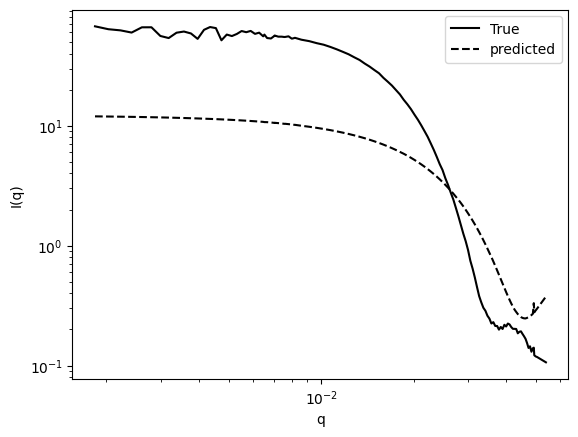

In [ ]:
fig, ax = plt.subplots()
ax.loglog(data.x, data.y, color='k', label='True')
ax.loglog(data.x, problem.fitness.theory(), color='k', ls='--', label='predicted')
ax.set_xlabel('q')
ax.set_ylabel('I(q)')
ax.legend()
plt.show()